# Preprocessing

In [1]:
# Allow Collab to connect to your Drive
from google.colab import drive
drive.mount('/content/drive')

# Path to the data on Drive
root = "/content/drive/MyDrive/PhD/Integrated_Gradient"


Mounted at /content/drive


In [2]:
!pip install torchsummary

In [3]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torchsummary import summary
import matplotlib.pyplot as plt
import os, time, math, copy
import numpy as np


In [4]:
# Checking if GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    use_cuda = True
else:
    device = torch.device("cpu")
    use_cuda = False
print("Found:",torch.cuda.device_count(), device)


Found: 1 cuda


In [5]:
# Load the MNIST dataset
def get_mnist_dataloaders(val_percentage=0.1, batch_size=1):
    """Get train-valid-test data loaders"""   
    
    dataset = datasets.MNIST(f"{root}/dataset", train=True,  download=True, transform=transforms.ToTensor())
    dataset_test = datasets.MNIST(f"{root}/dataset", train=False,  download=True, transform=transforms.ToTensor())

    len_train = int(len(dataset) * (1 - val_percentage))
    len_val = len(dataset) - len_train
    dataset_train, dataset_val = random_split(dataset, [len_train, len_val])

    data_loader_train = DataLoader(dataset_train, batch_size = batch_size, shuffle = True, num_workers = 2)
    data_loader_val = DataLoader(dataset_val, batch_size = batch_size, shuffle = True, num_workers = 2)
    data_loader_test = DataLoader(dataset_test, batch_size = batch_size, shuffle = True, num_workers = 2)

    return data_loader_train, data_loader_val, data_loader_test, len_train, len_val, len(dataset_test)


torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])


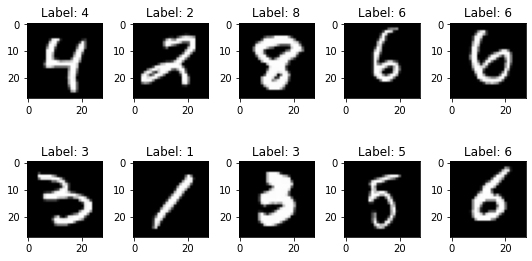

In [6]:
def plot_samples():
    """ Plot MNIST digits"""   
    a, _, _ , _, _, _= get_mnist_dataloaders()
    num_row = 2
    num_col = 5# plot images
    num_images = num_row * num_col
    fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
    for i, (x,y) in enumerate(a):
        if i >= num_images:
            break
        print(x.shape)
        ax = axes[i//num_col, i%num_col]
        x = (x.numpy().squeeze().reshape(28, 28) * 255).astype(int)
        y = y.numpy()[0]
        ax.imshow(x, cmap='gray')
        ax.set_title(f"Label: {y}")
        
    plt.tight_layout()
    plt.show()
    
plot_samples()


# CNN

In [17]:
class CNN(nn.Module):
    """Small sized network """    
    def __init__(self, name, map = 5, stride = 1):
        self.name = name
        fc_output_size  = 50
        map_size        = map   #(3,5,7,9,11,...)
        block1_features = 25
        block2_features = 50
        stride          = stride
        
        super().__init__()

        # Activation function
        if self.name.split("_")[0] == "smooth":
            self.a = torch.nn.Softplus()
        else: 
            self.a = torch.nn.ReLU()

        # Conv block 1
        self.conv1 = nn.Conv2d(1, block1_features, map_size, padding = 1, stride = stride)
        fc_input_size = np.floor((28 - map_size +2 * 1) / stride + 1)     

        # Max pooling
        fc_input_size /= 2
        
        # Conv block 2
        self.conv3 = nn.Conv2d(block1_features, block2_features, map_size, padding = 1, stride = stride)
        fc_input_size = np.floor((-map_size + 2 * 1 + fc_input_size) / stride + 1)  

        # Max pooling
        fc_input_size /= 2
        
        # Fully connected layers
        self.fc1 = nn.Linear(block2_features * int(fc_input_size) ** 2, fc_output_size)
        self.fc2 = nn.Linear(fc_output_size, 10)        

    def forward(self, x):
        x = self.a(self.conv1(x))
        x = F.max_pool2d(x, 2)    
        x = self.a(self.conv3(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)       
        x = self.a(self.fc1(x))
        x = self.fc2(x)

        return x
        

# Experiments

In [9]:
# Go through the whole database and compute average loss and accuracy
def accuracy_and_loss_whole_dataset(data_loader, len_data, model):
    """Compute the accuracy and cross-entropy loss on all examples in the
    data loader"""
    losses = 0
    accuracies = 0
    loss_func = nn.CrossEntropyLoss(reduction = 'sum')
    model.eval()

    with torch.no_grad():
        for x, y in data_loader:

            x = x.to(device=device)
            x = 2 * x - 1
            y = y.to(device=device)

            output = model(x)

            losses += loss_func(output, y).item()
            accuracies += (y == torch.argmax(output, axis = 1)).sum().item()
    model.train()
    return accuracies / len_data, losses / len_data


In [10]:
class Logger:
    " Simple logger to track progress during training"
    def __init__(self):
        self.losses_train = []
        self.losses_valid = []
        self.accuracies_train = []
        self.accuracies_valid = []

    def log(self, accuracy_train = 0, loss_train = 0, accuracy_valid = 0, loss_test = 0):
        self.losses_train.append(loss_train)
        self.accuracies_train.append(accuracy_train)
        self.losses_validt.append(loss_valid)
        self.accuracies_validt.append(accuracy_valid)

def plot_learning_curve(train_curve, val_curve, ticks = 2):
    plt.figure()
    plt.plot(train_curve, label="Train")
    plt.plot(val_curve, label="Validation")
    plt.legend(loc = 'best')
    plt.xlabel("Epoch")
    plt.grid(True, alpha = 0.5)
    plt.xticks(ticks = np.arange(0, len(train_curve), 2), 
               label = np.arange(0, len(train_curve), 2))
    

In [11]:
def store_model(model):
    """ Store the best model """
    torch.save(model.state_dict(), f"{root}/models/{model.name}.pt")
    
def load_model(model):
    """ Get the best model """
    model.load_state_dict(torch.load(f"{root}/models/{model.name}.pt"))


In [12]:
def mixup_data(x, y, alpha):
    '''Compute the mixup data. Return mixed inputs, pairs of targets, and lambda'''    
    if alpha > 0.:    
        lam = np.random.beta(alpha, alpha)    
    else:    
        lam = 1.    
    batch_size = x.size()[0]    
    index = torch.randperm(batch_size).to(device) 
    mixed_x = lam * x + (1 - lam) * x[index,:]    
    y_a, y_b = y, y[index]       
    return mixed_x, y_a, y_b, lam

In [13]:
def mixed_cross_entropy(logit, y_a, y_b, lam):
    """ Mixed cross-entropy loss with target lamba y1 + (1 - lamba) y2 """
    p = nn.Softmax(dim = -1)(logit)
    loss = lam * torch.log(p[torch.arange(logit.shape[0]), y_a]) + \
           (1 - lam) * torch.log(p[torch.arange(logit.shape[0]), y_b])
    return -1 * loss.mean()


In [14]:
def train(model, lr = 1e-4, nb_epochs = 10, batch_size = 32, input_mixup = False):

    data_loader_train, data_loader_val, _, len_train, len_val, _ = get_mnist_dataloaders(0.1, batch_size = batch_size)

    best_accuracy_val = 0
    logger = Logger()
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    
    loss_func = nn.CrossEntropyLoss()

    for epoch in range(nb_epochs):
        current_loss = 0
        current_acc = 0
        batch_idx = 1
        for x, y in data_loader_train:
            
            if batch_idx % 200 == 0:
                print(f"Train Epoch: {epoch + 1} [{batch_idx * batch_size} / {len_train}]")
            
            x = x.to(device=device)
            x = 2 * x - 1

            # If it is required to apply input mixup
            if input_mixup:
                x, y_a, y_b, lam = mixup_data(x, y, 0.1)

            y = y.to(device=device)

            output = model(x)

            ## If it is required to apply input mixup
            if input_mixup:
                loss = mixed_cross_entropy(output, y_a, y_b, lam)
            else:
                loss = loss_func(output, y)

            optim.zero_grad()
            loss.backward()

            optim.step()
            batch_idx += 1

        # Compute train-valid performance during training
        accuracy_train, loss_train = accuracy_and_loss_whole_dataset(data_loader_train, len_train, model)
        accuracy_val, loss_val     = accuracy_and_loss_whole_dataset(data_loader_val, len_val, model)
        
        # Record best model
        if accuracy_val > best_accuracy_val:
            best_accuracy_val = accuracy_val
            #store_model(model)
        
        logger.log(accuracy_train, loss_train, accuracy_val, loss_val)

        print("\n" + \
            f"Train: loss={loss_train:.3f}, accuracy={accuracy_train*100:.1f}%  \t" + \
            f"Validation: loss={loss_val:.3f}, accuracy={ accuracy_val*100:.1f}% \n", flush=True)

    return logger


In [18]:
model = CNN("smooth_CNN_mixup").to(device)
print(model)
summary(model, (1, 28, 28))

CNN(
  (a): Softplus(beta=1, threshold=20)
  (conv1): Conv2d(1, 25, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(25, 50, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1250, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 25, 26, 26]             650
          Softplus-2           [-1, 25, 26, 26]               0
            Conv2d-3           [-1, 50, 11, 11]          31,300
          Softplus-4           [-1, 50, 11, 11]               0
            Linear-5                   [-1, 50]          62,550
          Softplus-6                   [-1, 50]               0
            Linear-7                   [-1, 10]             510
Total params: 95,010
Trainable params: 95,010
Non-trainable params: 0
---------------------------------

In [19]:
# Main training loop
learning_rate = 1e-4
batch_size = 128

begin = time.time()
log = train(model, nb_epochs = 40, lr = learning_rate, batch_size = batch_size, input_mixup = True)
end = time.time()

Train Epoch: 1 [25600 / 54000]
Train Epoch: 1 [51200 / 54000]

Train: loss=0.511, accuracy=85.0%  	Validation: loss=0.497, accuracy=85.7% 

Train Epoch: 2 [25600 / 54000]
Train Epoch: 2 [51200 / 54000]

Train: loss=0.356, accuracy=90.0%  	Validation: loss=0.343, accuracy=90.5% 

Train Epoch: 3 [25600 / 54000]
Train Epoch: 3 [51200 / 54000]

Train: loss=0.273, accuracy=92.5%  	Validation: loss=0.262, accuracy=92.8% 

Train Epoch: 4 [25600 / 54000]
Train Epoch: 4 [51200 / 54000]

Train: loss=0.222, accuracy=94.3%  	Validation: loss=0.212, accuracy=94.3% 

Train Epoch: 5 [25600 / 54000]
Train Epoch: 5 [51200 / 54000]

Train: loss=0.194, accuracy=94.9%  	Validation: loss=0.187, accuracy=94.8% 

Train Epoch: 6 [25600 / 54000]
Train Epoch: 6 [51200 / 54000]

Train: loss=0.171, accuracy=95.9%  	Validation: loss=0.165, accuracy=95.8% 

Train Epoch: 7 [25600 / 54000]
Train Epoch: 7 [51200 / 54000]

Train: loss=0.138, accuracy=96.8%  	Validation: loss=0.134, accuracy=96.7% 

Train Epoch: 8 [2560

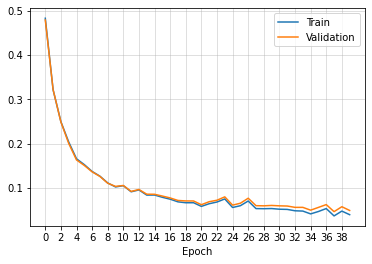

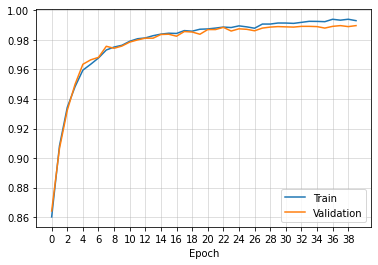

In [ ]:
plot_learning_curve(log.losses_train, log.losses_test)
plt.savefig(f"{root}/results/CNN/{model.name}_loss.pdf", bbox_inches='tight')
plot_learning_curve(log.accuracies_train, log.accuracies_test)
plt.savefig(f"{root}/results/CNN/{model.name}_acc.pdf", bbox_inches='tight')

In [20]:
# Test set accuracy
_, _, data_loader_test, _, _, len_test = get_mnist_dataloaders(0.1, batch_size = 1000)
load_model(model)
accuracy_test, _= accuracy_and_loss_whole_dataset(data_loader_test, len_test, model)
print(f"{100 * accuracy_test: .2f}%")

 99.00%


In [ ]:
# Store erroneous predictions
def store_errors(model):
    
    num_errors = 0
    _, _, data_loader_test, _, _, len_test = get_mnist_dataloaders(0, batch_size = 1)
    total_time = 0
    for x, y in data_loader_test:

        x = x.to(device=device)
        x = 2 * x - 1
        y = y.to(device=device)

        output = model(x)

        pred = torch.argmax(output, axis = -1).item()

        if not pred == y:
            # Plot images with errors
            plt.figure()
            plt.imshow(x.cpu().reshape(28, 28), cmap = 'gray')
            plt.tight_layout()
            plt.savefig(f"{root}/results/CNN/error_{num_errors}_{y.item()}_pred_{pred}.pdf", bbox_inches='tight')
            num_errors += 1
            if num_errors == 10:
                break

store_errors(model)